Notes:
    
14Apr15: *Changed Model's 'test' method to take the type of report as input. We should be using AUC most of the time (that is how the comp is scored) but might be useful to use classificaition report sometimes.
*Classes start with caps, functions/methods in camel case

TODO:
*Add getter to "model" for classification results

*Fix init (Mike to do) to make pythonic. Also have it accept params so our classes can be used for grid searching WITHOUT breaking existing classes

*Make GridSearchCV work

*Visualize all numeric data

*Normalize data?

In [1]:
'''
This cell's function:
Import all libraries that will be needed throughout document
'''
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import json
from pprint import pprint
import datetime
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Text processing libraries
from nltk.stem import PorterStemmer
#####################import enchant.checker #CAN't INSTALL THIS SINCE I HAVE 64 BIT PYTHON :( Michael
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize

# PCA / GMM
import time
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm   


In [2]:
class Data_handler():
    
    if __name__ == "__main__":
        dfTrain_full = pd.DataFrame()
        dfTest = pd.DataFrame()
        dfTrain = pd.DataFrame()
        dfDev = pd.DataFrame()
        trainColumnNames = []
        testColumnNames = []
    
    def initialize_data(self,train_json, test_json, prop_train):
        #Load in data as panda dataframes
        with open(train_json,'r') as fp: 
            json_data = json.load(fp)
        self.dfTrain_full = pd.io.json.json_normalize(json_data)

        with open(test_json,'r') as fp: 
            json_data = json.load(fp)
        self.dfTest = pd.io.json.json_normalize(json_data)

        # Set np seed
        np.random.seed(0)

        #Shuffle train data and split into train and dev
        self.dfTrain_full.reindex(np.random.permutation(self.dfTrain_full.index)) #shuffle
        nTrain_full = self.dfTrain_full.shape[0]
        self.dfTrain = self.dfTrain_full[:int(nTrain_full*prop_train)]
        self.dfDev = self.dfTrain_full[int(nTrain_full*prop_train):]
        
        #Save number of observations in train and dev
        nTrain = self.dfTrain.shape[0]
        nDev = self.dfDev.shape[0]

        #Save column names for reference
        self.trainColumnNames = self.dfTrain.columns.tolist()
        self.testColumnNames = self.dfTest.columns.tolist() #Note test features is only a subset!
        
        return nTrain_full, nTrain, nDev ################# WHY DOES THIS GET RETURNED? WHAT IS IT USED FOR?
    
    def getTrainFull(self):
        return self.dfTrain_full   
    def getTest(self):
        return self.dfTest   
    def getTrain(self):
        return self.dfTrain   
    def getDev(self):
        return self.dfDev    
    def getTrainColumnNames(self):
        return self.trainColumnNames   
    def getTestColumnNames(self):
        return self.testColumnNames
    
# Load in our data to master_data. Proportion in train vs dev is set here. Changing it will take effect throughout everything else in the script (the magic of classes!)
master_data = Data_handler()
master_data.initialize_data('train.json', 'test.json',.75)


(4040, 3030, 1010)

In [3]:
class FeatureEngineer():
    '''
    Module that contains some of our feature engineering methods. 
    Does not contain instance variables!
    Outputs np arrays or dataframes as needed
    '''
    def unionText(self,df):
        req_text = df['request_text_edit_aware'].values
        title_text = df['request_title'].values
        merged_text = []
        for i in range(req_text.shape[0]):
            merged_text.append(title_text[i]+' '+req_text[i])
        merged_text_array = np.asarray(merged_text)
        return merged_text_array
        
    def separateTimestamp(self,df):
        '''
        separates time stamp (UTC) into month, day, hour. If user's local time is of interest, 
        use the non UTC data
        input: any dataFrame containing the timestamp data
        '''

        timeStamps = df['unix_timestamp_of_request_utc'].values #numpy array of timestamps
        timeStampsSeparate = [] #init new

        # Loop over timestamps
        for ts in timeStamps:
            # Pull out relevant time info
            d = datetime.datetime.fromtimestamp(ts)
            month = d.strftime("%m")
            day_of_month = d.strftime("%d")
            hour = d.strftime("%H")
            # Append to results
            timeStampsSeparate.append([int(month),int(day_of_month),int(hour)])
        
        #manually create labels
        labels = ['month','day_of_month','hour']
        #convert from python list to ndarray
        return np.asarray(timeStampsSeparate), labels

    def newTimeInfo(self,df):
        '''
        New expressions of time e.g day of week
        '''
        
        timeStamps = df['unix_timestamp_of_request'].values #LOCAL time
        timeStampsSeparate = [] #init new

        # Loop over timestamps
        for ts in timeStamps:
            # Pull out relevant time info
            d = datetime.datetime.fromtimestamp(ts)
            day_of_week = d.isoweekday()
            local_time =d.strftime("%H")
            # Append to results
            timeStampsSeparate.append([int(day_of_week),int(local_time)])
        
        #manually create labels
        labels = ['day_of_week','local_time']        
        #convert from python list to ndarray
        return np.asarray(timeStampsSeparate), labels
        
    def selectedNumericFeatures(self,df):
        '''
        Some hand picked numeric features that seem to work well in logistic regression
        Dependency: separateTimestamp
        '''
        colNames = [master_data.getTestColumnNames()[i] for i in [5,7,8,9]] #hand picked to be plausible, not optimal 
        #numeric data
        dfNum = df[colNames].values
        #convert time stamp into nice format
        dfTime, labelsTime = self.separateTimestamp(df)
        #merge
        combinedData = np.column_stack((dfNum,dfTime))
        combinedLabels = colNames+labelsTime
        return combinedData, combinedLabels
    
    def allNumericFeatures(self,df):
        '''
        All of the numeric features that come standard.
        Dependency: separateTimestamp
        '''
        colNames = [master_data.getTestColumnNames()[i] for i in [4,5,6,7,8,9,10,12,13]] 
        #numeric data
        dfNum = df[colNames].values
        #convert time stamp into nice format
        dfTime, labelsTime = self.separateTimestamp(df)
        ##new time
        #dfTimeNew, labelsTimeNew = self.newTimeInfo(df)
        #merge
        combinedData = np.column_stack((dfNum,dfTime))#,dfTimeNew))
        combinedLabels = colNames+labelsTime#+labelsTimeNew
        return combinedData, combinedLabels
    
    def simpleNewFeatures(self,df):
        '''
        Basic self explanatory features.
        Input: whole df
        '''
        
        #From text
        title_length = [len(t) for t in df['request_title'].values]
        req_length = [len(t) for t in df['request_text_edit_aware'].values]
        avg_word_length = [float(len(t))/len(t.split(' ')) for t in df['request_text_edit_aware'].values] #complexity of lang
        title_caps_norm = [sum(1 for c in t if c.isupper())/(float(len(t))+1) for t in df['request_title'].values]
        req_caps_norm = [sum(1 for c in t if c.isupper())/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        #num_all_caps_words
        #num_repeated_words #perhaps normalize and/or remove shorter words
        
        ###special chars in text
        num_numbers_norm = [sum(1 for c in t if c.isdigit())/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        num_currency_chars_norm = [sum(1 for c in t if c in '$')/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        num_exclamation_norm = [sum(1 for c in t if c in '!')/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        num_commas_norm = [sum(1 for c in t if c in ',')/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        ######has hyperlink?? 
        
        ###language
        #grammar_errors #normalized for request length
        #spelling_errors #normalized for request length
        
        f = np.asarray([title_length,
                          req_length,
                          avg_word_length,
                          title_caps_norm,
                          req_caps_norm,
                          num_numbers_norm,
                          num_currency_chars_norm,
                          num_exclamation_norm,
                          num_commas_norm]).T
        
        labels = ['title_length',
                  'req_length',
                  'avg_word_length',
                  'title_caps_norm',
                  'req_caps_norm',
                  'num_numbers_norm',
                  'num_currency_chars_norm',
                  'num_exclamation_norm',
                  'num_commas_norm']
        
        return f,labels
    
    def augNumericFeatures(self,df):
        f1, l1 = self.simpleNewFeatures(df)
        f2, l2 = self.allNumericFeatures(df)
        return np.column_stack((f1,f2)),l1+l2
    
    def reducedEnsemble(self,df):
        '''
        reduced set of numeric + ensemble features for use in DT or RF 
        '''
        colNames = [master_data.getTestColumnNames()[i] for i in [4,10,12,13]] 
        #numeric data
        f_num = df[colNames].values
        f,l = self.simpleNewFeatures(df)
        l_new = np.asarray(l)[[0,1,2,3,4,8]].tolist()
        f_new = f[:,[0,1,2,3,4,8]]
        #merge
        combinedData = np.column_stack((f_num,f_new))
        combinedLabels = colNames+l_new
        return combinedData, combinedLabels
        
        
    def customNGrams(self,df):
        '''
        N Grams built by intuition
        '''
        #pay_it_forward = some regex to find phrase "pay it forward"
        raise NotImplementedError

    def vectorize(self,raw_fit,raw_predict,params={}):
        # transform the train data
        vectorizer_train = CountVectorizer(**params)
        fit_data = vectorizer_train.fit_transform(raw_fit)
        feature_names = vectorizer_train.get_feature_names()
        # transform the dev data using the same vocab
        predict_data = vectorizer_train.transform(raw_predict)     # 'transform' function will preserve previous vocab
        return fit_data, predict_data, feature_names

    def reVectorizer(self,fitted_model,n_keep = 100):
        '''
        This vectorizer prunes features away based on the importance rated by fitted_model.
        '''
        #extract data from fitted_model
        c = fitted_model.c
        importances = c.coef_[0,:]
        old_names = fitted_model.feature_names
        old_fit_data = fitted_model.fit_data
        old_predict_data = fitted_model.predict_data

        #sort features by importance
        ind = np.argsort(-np.absolute(importances))[:n_keep]

        #create pruned feature set
        new_names = np.asarray(old_names)[ind]
        new_fit = old_fit_data[:,ind]
        new_predict = old_predict_data[:,ind]
        
        return new_fit,new_predict,new_names
        
fe = FeatureEngineer()


In [4]:
'''
Topic modelling
'''


########
n_samples = master_data.getTrain().shape[0]
n_features = 400
n_topics = 10
n_top_words = 20

#Load data
t0 = time.time()
fit_data = master_data.getTrain()[:n_samples]
predict_data = master_data.getDev()

#get text
fit = fe.unionText(fit_data)
predict = fe.unionText(predict_data)

#vectorize with cleaning data
print "Loading dataset and extracting TF-IDF features..."
vec = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,stop_words='english')
fit_tf = vec.fit_transform(fit)
predict_tf = vec.transform(predict)
print "done in %0.3fs." % (time.time() - t0)

#Fit NMF
print "Fitting the NMF model with n_samples=%d and n_features=%d..." % (n_samples, n_features)
nmf = NMF(n_components=n_topics, random_state=1)
fit_nmf = nmf.fit(fit_tf)
print "done in %0.3fs." % (time.time() - t0)

Loading dataset and extracting TF-IDF features...
done in 0.381s.
Fitting the NMF model with n_samples=3030 and n_features=400...
done in 488.000s.


C:\Anaconda\lib\site-packages\sklearn\decomposition\nmf.py:533: UserWarning: Iteration limit reached during fit
  warnings.warn("Iteration limit reached during fit")


In [7]:
feature_names = vec.get_feature_names()

print fit_nmf


print nmf.components_.shape
print nmf.reconstruction_err_
print type(fit_nmf)

#Transform data
fit_topics = fit_nmf.transform(fit_tf)
predict_topics = fit_nmf.transform(predict_tf)



for topic_idx, topic in enumerate(fit_nmf.components_):
    print "Topic #%d:" % topic_idx
    print " ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]])
    print ''



NMF(beta=1, eta=0.1, init=None, max_iter=200, n_components=10,
  nls_max_iter=2000, random_state=1, sparseness=None, tol=0.0001)
(10L, 400L)
50.6095045728
<class 'sklearn.decomposition.nmf.NMF'>
Topic #0:
really use pizza appreciate right don craving haven good pick kind afford hot sick thanks usa cash boyfriend hours months

Topic #1:
pizza love tonight like usa craving thanks eat buy hut ll random send awesome free great dinner night hey cheese

Topic #2:
broke hungry student college finals help students studying im kid pretty appreciate starving need appreciated poor greatly meal university usa

Topic #3:
com http imgur jpg www reddit picture proof edit birthday pizza draw trade send post offer like california make cat

Topic #4:
food money house eat days need left appreciated spent don couple week home starving buy month stamps eaten live ran

Topic #5:
help family time friend dinner kids know tonight thanks night going year make mom like little thank old people able

Topic #6:
day

In [26]:
fit_labels = master_data.getTrain()['requester_received_pizza'].values.astype(int)
predict_labels = master_data.getDev()['requester_received_pizza'].values.astype(int)
print predict_labels

print fit_topics.shape

'''
lr = BernoulliNB(binarize=0.1)
lr.fit(fit_topics,master_data.getTrain()['requester_received_pizza'].values)
pred = lr.predict(predict_topics)
print(metrics.roc_auc_score(pred,predict_labels))
'''
p = PCAGMM(master_data.getTrain(),master_data.getDev())
p.fit_data = fit_topics
p.predict_data = predict_topics
p.run_model()
p.test()

[0 0 1 ..., 0 0 0]
(3030L, 10L)


0.5726321844539789

In [37]:
class PCAGMM_extended(PCAGMM):
    '''
    PCA followed by GMM
    Uses Topic Modelling data AND Numeric features
    '''
    def __init__(self,dfFit,dfPredict,k=3,cov_type='spherical',n=6,**kwargs):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = GMM
        #hyperparams
        self.k = k #number of PCA dimensions
        self.cov_type = cov_type
        self.n = n #number of GMM components
        #how to process data
        f1,l1 = fe.augNumericFeatures(self.dfFit)
        p1,_ = fe.augNumericFeatures(self.dfPredict)
        f2,p2,l2 = fe.topicModeller(self.dfFit,self.dfPredict) #WARNING NOT IMPLEMENTED YET
        f_c = np.column_stack((f1,f2))
        p_c = np.column_stack((p1,p2))
    
        self.feature_names = self.conductPCA(f_c,p_c)

In [33]:
pcagmm_extended = PCAGMM_extended(master_data.getTrain(),master_data.getDev())
pcagmm_extended.run_model()
print pcagmm_extended.test()

0.589398329191


In [174]:
print 
numpy.percentile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)


SyntaxError: invalid syntax (<ipython-input-174-55b122143f24>, line 1)

In [11]:
class Model(object):
    '''
    In Model and child classes, we use Fit and Predict for data sets to avoid confusion. These 
    can actually be train, dev or test in various combinations depending on how it is initialized.
    '''
    def __init__(self,dfFit,dfPredict):
        self.dfFit = dfFit
        self.dfPredict = dfPredict
        self.fit_labels = self.dfFit['requester_received_pizza'].values
    
    """
    def mod_for_ensemble(self):
        '''
        Replace test data with train again. 
        Use this after init_test or init_final if you want to predict on the same data you fit with.
        '''
        self.test_data = self.train_data
        self.prediction = np.zeros((len(self.test_data.values))) 
    
    def init_final(self):
        self.train_data = master_data.getTrainFull()
        self.test_data = master_data.getTest()
        self.prediction = np.zeros((len(self.test_data.values)))
        self.train_labels = self.train_data['requester_received_pizza'].values
    """
    def test(self,criteria=metrics.roc_auc_score):
        try:
            predict_labels = self.dfPredict['requester_received_pizza'].values
            return criteria(predict_labels,self.prediction)
        except:
            return "Failed! 'dfPredict' has no labels, no prediction present or invalid test criteria"
    
    def writeSubmission(self,fileName='submit_to_kaggle.csv'):
        try:
            '''
            Ensure the test data hasn't been shuffled or your labels won't match the request_id's.
            '''
            #extract request_id so we can match against predictions for submission to kaggle
            req = self.dfPredict['request_id']
            #make prediction into a pandas series
            print self.prediction.astype(int)
            pred_series = pd.Series(self.prediction.astype(int),name="requester_received_pizza")
            #now join into data frame
            out = pd.concat([req,pred_series], axis=1)
            #write data frame to csv (using kaggles sample submission csv for correct format)
            out.to_csv(fileName,index=False)
            print "Written to File!"
        except:
            return "Failed! Is 'dfPredict' the test set?"
    
    def getPrediction(self):
        return self.prediction
    
    def gridSearch(self,params):
        '''
        implement GridSearchCV in class
        '''
        gs = GridSearchCV(self.classifier(),params,scoring='roc_auc')
        gs.fit(self.fit_data,self.fit_labels)
        print gs.best_params_
        return gs
    
    def crossVal(self,params=None):
        '''
        Implement cross validation score
        '''
        scores = cross_val_score(self.classifier(**params),
                                 self.fit_data,
                                 self.fit_labels,
                                 cv=4, scoring='roc_auc')
        print "Mean AUC:", np.mean(scores)
        return scores


In [12]:
class Baseline(Model):
    '''
    Any model just needs to implicitly inherit the model class
    -Test this with baseline(master_data.getTrain(),master_data.getDev()) and
                   baseline.test()
    -Generate output with baseline(master_data.getTrainFull(),master_data.getTest()) and
                         baseline.writeSubmission()
    
    This is the first model we submitted to Kaggle
    '''
    def __init__(self,dfFit,dfPredict,params={}):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = LogisticRegression
        self.params = params
        #how to process data
        raw_fit = fe.unionText(self.dfFit)
        raw_predict = fe.unionText(self.dfPredict)
        self.fit_data, self.predict_data, self.feature_names = fe.vectorize(raw_fit,raw_predict,params)

    def run_model(self):
        self.prediction = self.log_reg()

    def log_reg(self):
        self.c = self.classifier()
        self.c.fit(self.fit_data, self.fit_labels)
        lor_pred = self.c.predict(self.predict_data)
        # Return the prediction matrix, coefficients
        return lor_pred

    def extractFeatureImportance(self,n=50):
        importances = self.c.coef_[0,:]
        stdDev = np.zeros(importances.shape)
        ind = np.argsort(-np.absolute(importances))[:n]
        importances_sorted = importances[ind]
        importances_names = np.asarray(self.feature_names)[ind]
        stdDev_sorted = stdDev[ind]
        return importances_names,importances_sorted,stdDev_sorted

In [13]:
class BaselineTuned(Baseline):
    '''
    Overhaul log_reg function to include tuned params
    params found by running tuneBaseline() in Experiments cell
    '''
    def log_reg(self):
        self.c = self.classifier(penalty='l1',C=0.092)
        self.c.fit(self.fit_data, self.fit_labels)
        lor_pred = self.c.predict(self.predict_data)
        # Return the prediction matrix, coefficients
        return lor_pred


In [14]:
class NumericModel(Model):
    '''
    Simple models with numeric data straight out of df
    '''
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = GaussianNB
        #how to process data
        self.fit_data,self.feature_names = fe.augNumericFeatures(self.dfFit)
        self.predict_data,_ = fe.augNumericFeatures(self.dfPredict)
    
    def run_model(self):
        #predict
        self.prediction = self.classify()    
    
    def classify(self):
        self.c = self.classifier()
        self.c.fit(self.fit_data, self.fit_labels)
        return self.c.predict(self.predict_data) 
    
    def extractFeatureImportance(self):
        '''
        WARNING: Not sure if this is meaningful since data is not normalized.
        May only be meaningful with text data because that represents word counts.
        '''
        pass
        '''
        importances = self.c.coef_[0,:]
        stdDev = np.zeros(importances.shape)
        ind = np.argsort(-np.absolute(importances))
        importances_sorted = importances[ind]
        importances_names = np.asarray(self.feature_names)[ind]
        stdDev_sorted = stdDev[ind]
        return importances_names,importances_sorted,stdDev_sorted
        '''

In [15]:
class DecisionTreeModel(Model):
    '''
    Basic decision tree. Runs on numeric features
    '''
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = DecisionTreeClassifier
        #how to process data
        self.fit_data,self.feature_names = fe.augNumericFeatures(self.dfFit)
        self.predict_data,_ = fe.augNumericFeatures(self.dfPredict)
    
    def run_model(self):
        self.prediction = self.classify()  
    
    def classify(self):
        self.c = self.classifier(criterion='entropy',max_depth=5) #criterion can be 'gini' or 'entropy'
        self.c.fit(self.fit_data, self.fit_labels)
        return self.c.predict(self.predict_data) 
        
    def extractFeatureImportance(self):
        importances = self.c.feature_importances_
        stdDev = np.zeros(importances.shape)
        ind = np.argsort(-importances)
        importances_sorted = importances[ind]
        importances_names = np.asarray(self.feature_names)[ind]
        stdDev_sorted = stdDev[ind]
        return importances_names,importances_sorted,stdDev_sorted

In [16]:
class RandomForestModel(Model):
    '''
    Random Forest   
    '''
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = RandomForestClassifier
        #how to process data
        self.fit_data,self.feature_names = fe.augNumericFeatures(self.dfFit)
        self.predict_data,_ = fe.augNumericFeatures(self.dfPredict)
    
    def run_model(self):
        #predict
        self.prediction = self.classify()  
    
    def classify(self):
        self.c = self.classifier(**{'criterion': 'entropy','n_estimators':100})#,
                                    #max_features=10) #criterion can be 'gini' or 'entropy'
        self.c.fit(self.fit_data, self.fit_labels)
        return self.c.predict(self.predict_data) 
    
    def extractFeatureImportance(self):
        stdDev = np.std([dTree.feature_importances_ for dTree in self.c],axis=0)
        importances = self.c.feature_importances_
        ind = np.argsort(-importances)
        importances_sorted = importances[ind]
        importances_names = np.asarray(self.feature_names)[ind]
        stdDev_sorted = stdDev[ind]
        return importances_names,importances_sorted,stdDev_sorted
        
    

In [17]:
class EnsembleForest(RandomForestModel):
    '''
    RF that incorporates text data via votes of another classifier
    BROKEN: Because ensemble1 init_test and doesn't ever init_final, you can't use this model's 
    init_final or finalize.
    '''
    def __init__(self,dfFit,dfPredict):
        RandomForestModel.__init__(self,dfFit,dfPredict)
        #how to process data
        self.ensembleFeatures()
    
    def ensembleFeatures(self):
        '''
        creates self.fit_data, self.predict_data and self.feature_names
        '''
        ###FIT features
        f1,l1 = fe.augNumericFeatures(self.dfFit) 
        #add outputs of tuned baseline classifier
        lvl1class = Baseline(self.dfFit,self.dfFit) #note predicts it's own train data!
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        l2 = ['lvl1classifier']
        self.fit_data = np.column_stack((f1,f2))
        ###FEATURE Labels
        self.feature_names = l1+l2
        ###PREDICT features
        f1,_ = fe.augNumericFeatures(self.dfPredict)
        lvl1class = Baseline(self.dfFit,self.dfPredict) #this time predict on predict data
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        self.predict_data = np.column_stack((f1,f2))
   

In [18]:
class EnsembleTree(DecisionTreeModel):
    '''
    RF that incorporates text data via votes of another classifier
    BROKEN: Because ensemble1 init_test and doesn't ever init_final, you can't use this model's 
    init_final or finalize.
    '''
    def __init__(self,dfFit,dfPredict):
        DecisionTreeModel.__init__(self,dfFit,dfPredict)
        #how to process data
        self.ensembleFeatures()
    
    def ensembleFeatures(self):
        '''
        creates self.fit_data, self.predict_data and self.feature_names
        '''
        ###FIT features
        f1,l1 = fe.reducedEnsemble(self.dfFit) 
        #add outputs of tuned baseline classifier
        lvl1class = BaselineTuned(self.dfFit,self.dfFit) #note predicts it's own train data!
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        l2 = ['lvl1classifier']
        self.fit_data = np.column_stack((f1,f2))
        ###FEATURE Labels
        self.feature_names = l1+l2
        ###PREDICT features
        f1,_ = fe.reducedEnsemble(self.dfPredict)
        lvl1class = BaselineTuned(self.dfFit,self.dfPredict) #this time predict on predict data
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        self.predict_data = np.column_stack((f1,f2))

In [19]:
class EnsembleNB(NumericModel):
    '''
    NB that incorporates text data via votes of another classifier
    BROKEN: Because ensemble1 init_test and doesn't ever init_final, you can't use this model's 
    init_final or finalize.
    '''
    def __init__(self,dfFit,dfPredict):
        NumericModel.__init__(self,dfFit,dfPredict)
        #how to process data
        self.ensembleFeatures()
    
    def ensembleFeatures(self):
        '''
        creates self.fit_data, self.predict_data and self.feature_names
        '''
        ###FIT features
        f1,l1 = fe.reducedEnsemble(self.dfFit) 
        #add outputs of tuned baseline classifier
        lvl1class = BaselineTuned(self.dfFit,self.dfFit) #note predicts it's own train data!
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        l2 = ['lvl1classifier']
        self.fit_data = np.column_stack((f1,f2))
        ###FEATURE Labels
        self.feature_names = l1+l2
        ###PREDICT features
        f1,_ = fe.reducedEnsemble(self.dfPredict)
        lvl1class = BaselineTuned(self.dfFit,self.dfPredict) #this time predict on predict data
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        self.predict_data = np.column_stack((f1,f2))

In [20]:
class EnsembleLR(Baseline):
    '''
    Merge Baseline Model features (pruned) with numeric features.
    '''
    def __init__(self,dfFit,dfPredict,mindf=1,maxdf=1.0,baseline_params={},ensemble_params={}):
        #hyperparams
        self.baseline_params = baseline_params
        self.ensemble_params = ensemble_params
        Baseline.__init__(self,dfFit,dfPredict)
        #classifier
        self.classifier = LogisticRegression
        #how to process data
        self.ensembleFeatures()
    
    def log_reg(self):
        self.c = self.classifier(**self.ensemble_params)
        self.c.fit(self.fit_data, self.fit_labels)
        lor_pred = self.c.predict(self.predict_data)
        # Return the prediction matrix, coefficients
        return lor_pred
    
    def ensembleFeatures(self):
        '''
        creates self.fit_data, self.predict_data and self.feature_names
        '''
        ###TEXT FEATURES
        e1 = Baseline(self.dfFit,self.dfPredict,self.baseline_params)
        e1.run_model()
        print "Baseline has this many words: ",e1.fit_data.shape
        ###prune BaselineTuned features
        f1,p1,l1 = fe.reVectorizer(e1,n_keep = 6000)
        print "after pruning, we are left wth this many words: ",f1.shape
        l1 = l1.tolist()
        ###NUMERIC FEATURES
        f2,l2 = fe.augNumericFeatures(self.dfFit) 
        p2,_ = fe.augNumericFeatures(self.dfPredict)
        f2 = normalize(f2)
        p2 = normalize(p2)

        ###COMBINE
        print p1.toarray().shape
        print p2.shape
        
        self.fit_data = np.column_stack((f1.toarray(),f2))
        self.feature_names = l1+l2      
        self.predict_data = np.column_stack((p1.toarray(),p2))
        '''
        self.fit_data = f1
        self.feature_names = l1     
        self.predict_data = p1    
        '''

In [22]:
b_params = {'min_df':0.01,'max_df':0.45}
elr = EnsembleLR(master_data.getTrain(),master_data.getDev(),baseline_params=b_params)
elr.run_model()
print b_params,' ',elr.test()

Baseline has this many words:  (3030, 765)
after pruning, we are left wth this many words:  (3030, 765)
(1010L, 765L)
(1010L, 21L)
{'max_df': 0.45, 'min_df': 0.01}   0.564235918708


In [114]:
#Run final
b_params = {'min_df':0.01,'max_df':0.45}
elr = EnsembleLR(master_data.getTrainFull(),master_data.getTest(),baseline_params=b_params)
elr.run_model()
elr.writeSubmission('ELR_pruned_submission.csv')

Baseline has this many words:  (4040, 695)
after pruning, we are left wth this many words:  (4040, 400)
(1631L, 400L)
(1631L, 21L)
[0 0 0 ..., 0 1 0]
Written to File!


In [27]:
class PCAGMM(Model):
    '''
    PCA followed by GMM
    '''
    def __init__(self,dfFit,dfPredict,k=3,cov_type='spherical',n=6,**kwargs):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = GMM
        #hyperparams
        self.k = k #number of PCA dimensions
        self.cov_type = cov_type
        self.n = n #number of GMM components
        #how to process data
        f1,l1 = fe.augNumericFeatures(self.dfFit)
        p1,_ = fe.augNumericFeatures(self.dfPredict)
        
        self.feature_names = self.conductPCA(f1,p1)
        """
        #Ensemble
        elr = EnsembleLR(dfFit,dfFit)
        elr.run_model()
        f2 = elr.prediction
        
        elr2 = EnsembleLR(dfFit,dfPredict)
        elr2.run_model()
        p2 = elr2.prediction
        
        l2 = ['ELR prediction']
        
        #Combine
        f_c = np.column_stack((f1,f2))
        p_c = np.column_stack((p1,p2))
        self.feature_names = self.conductPCA(f_c,p_c) + l2
        """
    def run_model(self):
        #predict
        self.prediction = self.classify()    
    
    def calcNumberParams(self,k,cm_type,n):
        '''
        Calculates number of parameters in model
        '''
        if cm_type=='spherical':
            return (k+1)*n*2
        elif cm_type=='tied':
            return (k)*n*2 + (k**2)*1*2 #first term is for mean vector, second is for cov matrix
        elif cm_type=='diag':
            return (k+k)*n*2
        elif cm_type=='full':
            return (k+k**2)*n*2
        else:
            raise ValueError('Invalid covariance matrix type')
    
    def conductPCA(self,f,p):
        #firstly normalize
        f = normalize(f)
        p = normalize(p)
        
        #transform data
        pca = PCA(n_components=self.k)
        fit_data_dimk = pca.fit_transform(f)
        predict_data_dimk = pca.transform(p)
        
        #save as instance vars
        self.fit_data = fit_data_dimk
        self.predict_data = predict_data_dimk
        return ['No Name']*self.k

    def classify(self):
     
        #separate into positive and negative classification examples
        fit_data_positive = self.fit_data[self.fit_labels,:]
        fit_data_negative = self.fit_data[~self.fit_labels,:]
        
        #fit GMMs
        g_pos = GMM(n_components=self.n,covariance_type=self.cov_type)
        g_pos.fit(fit_data_positive)
        g_neg = GMM(n_components=self.n,covariance_type=self.cov_type)
        g_neg.fit(fit_data_negative)

        #predict
        p_pos = g_pos.score(self.predict_data)
        p_neg = g_neg.score(self.predict_data)
        return (p_pos>p_neg).astype(int)
    

In [26]:
#Run test on PCAGMM model
params = {'k':3,'cov_type':'spherical','n':6}
pcagmm_model = PCAGMM(master_data.getTrain(),master_data.getDev(),**params)
pcagmm_model.run_model()
print pcagmm_model.test()

0.590055359414


In [53]:
class Preproc(Model):
   
    '''
    Preprocessor

    Things I tried and kept
    -remove apostrophes
    -remove punctuation
    -remove white space
    -stem words
    -keep only words that turn up in a US english dictionary

    Things I tried and removed
    -remove stop words
    -make all lowercase
    -try to correct misspelled words
    -rearranging changes
    
    Things I tried that failed, but I want to keep trying
    -SVM instead of logistic regression
    -TF-IDF transformation
    '''
    
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        #Mull over some options here
        #self.classifier = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)
        self.classifier = LogisticRegression(penalty='l2')
        #how to process data
        raw_fit = self.dfFit['request_text_edit_aware'].values
        raw_predict = self.dfPredict['request_text_edit_aware'].values
        self.fit_data, self.predict_data = self.vectorize(raw_fit,raw_predict,self.better_preprocessor)

    def run_model(self):
        self.prediction = self.log_reg()
        
    def better_preprocessor_mike(self,s):
        #remove plurals "es,s,ies" and other suffixes
        s = re.sub(r'(?<=\w)ies(?=\W|$)','y',s)
        #s = re.sub(r'(?<=\w)(?:es|ing|ly)(?=\W|$)','',s) #removes es,ing,ly
        #s = re.sub(r'(?<=\w)(?:es)(?=\W|$)','',s)
        s = re.sub(r'(?<=[bcdfghjklmnpqrtuvwxyz])(?:s|ed)(?=\W|$)','',s) #drop 's' or 'ed' if preceded by a consonant

        #remove any non letters, numbers, a few intersting chars, and whitespace
        #s = re.sub(r'[^\w\s,.!@$%]+','',s)

        #remove part of email addresses, keeping domain only
        #s = re.sub(r'(?<=\s)[a-zA-Z_.0-9]+@','@',s)

        #replace numbers with a single token
        #s = re.sub(r'[0-9]+','1',s)

        #delete mixed words/numbers
        #s = re.sub(r'(?<=\s)(?:\d+[a-zA-Z]+\w*|[a-zA-Z]+\d+\w*)(?=\W|$)','',s)

        #lowercase everything
        s = s.lower()

        #Delete everything except alpha and separators!
        #s = re.sub(r'[^a-zA-Z,\s\.]+','',s)

        return s
    
    def better_preprocessor(self,s):
        st = PorterStemmer()
        ##############################chkr = enchant.checker.SpellChecker("en_US")
        #print s
        #s = strip_accents_unicode(s).lower() #make everything lowercase
        s = re.sub('[?,-/><=+_!.:()]',' ',s) #turn a lot of punctuations into spaces
        s = ' '.join(s.split()) #remove excess white space
        ##############################s = " ".join(word for word in s.split() if chkr.check(word) == True)
        s = " ".join(st.stem(word) for word in s.split(" "))
        s = re.sub('[\']','',s) #remove apostrophes
        #print s
        return s
        
    def vectorize(self,raw_fit,raw_predict,prepro):
        # transform the train data
        vectorizer_train = CountVectorizer(preprocessor=prepro,stop_words='english')
        fit_data = vectorizer_train.fit_transform(raw_fit)
        #########################tfidf_transformer = TfidfTransformer()
        #########################fit_data_tfidf = tfidf_transformer.fit_transform(fit_data)

        # transform the dev data using the same vocab
        predict_data = vectorizer_train.transform(raw_predict)     # 'transform' function will preserve previous vocab
        ###########################predict_data_tfidf = tfidf_transformer.transform(predict_data)
        
        return fit_data, predict_data
        #return fit_data_tfidf, predict_data_tfidf

    def log_reg(self):
        lor = self.classifier
        lor.fit(self.fit_data, self.fit_labels)
        lor_pred = lor.predict(self.predict_data)
        # Return the prediction matrix, coefficients
        return lor_pred
    
# Run test of baseline
preproc_model = Preproc(master_data.getTrain(),master_data.getDev())
preproc_model.run_model()
print preproc_model.test()

0.555583701429


In [102]:
#Run NumericModel
numeric_model = NumericModel(master_data.getTrain(),master_data.getDev())
numeric_model.run_model()
print numeric_model.test()

0.530933194011


In [199]:
#Run test of decision tree
decision_tree_model = DecisionTreeModel(master_data.getTrain(),master_data.getDev())
decision_tree_model.run_model()
print decision_tree_model.test()


0.507485922666


In [36]:
"""
EXPERIMENTS Cell
Cell for all experiments that don't fit neatly elsewhere.
"""

def correlationVis(df):
    '''
    visualize correlations between variables for Error Analysis
    '''
    pass

def tuneBaseline():
    '''
    Conducts a GridSearch of LR params
    Visualizes result - useful to discern if result is from overfitting or not
    WARNING: Takes several minutes!
    '''

    #initiate a Baseline obj
    baseline_model = Baseline(master_data.getTrain(),master_data.getDev())

    ####Run grid search
    params = {'penalty': ['l1','l2'],'C':np.logspace(-2,2,30)}
    gs = baseline_model.gridSearch(params)

    ####Print and plot results
    scores = gs.grid_scores_

    l1_means = []
    l2_means = []
    C = []

    for i in range(len(gs.grid_scores_)):
        #append to relevant means vector
        if scores[i][0]['penalty'] == 'l1':
            l1_means.append(scores[i][1])
            #append C vector
            C.append(scores[i][0]['C'])
        elif scores[i][0]['penalty'] == 'l2':
            l2_means.append(scores[i][1])
        else:
            raise ValueError("function can't handle given params")

    #plot   
    plt.plot(C,l1_means,C,l2_means,'r')
    #plt.plot()
    plt.semilogx()
    plt.legend(['l1 penalty','l2 penalty'],'best')
    plt.show()

def compareTunedBaseline():
    '''
    This cell demonstrates Cross Val and GridSearch coming up with optimistic results and unhelpful params
    '''

    # Run test of baseline
    baseline_model = Baseline(master_data.getTrain(),master_data.getDev())
    baseline_model.run_model()
    print baseline_model.test()
    #featureImportanceVisualizer(baseline_model) 

    # Run test of BaselineTuned
    tuned = BaselineTuned(master_data.getTrain(),master_data.getDev())
    tuned.run_model()
    print 'test result: ', tuned.test()

    crossVal = tuned.crossVal({'penalty': 'l1', 'C': 0.092})
    print 'Cross Val is being overly optimistic again!'
    #featureImportanceVisualizer(tuned) 

def tuneEnsembleTree():
    '''
    Conducts a GridSearch of DT params
    Visualizes result - useful to discern if result is from overfitting or not
    WARNING: Takes several minutes!
    '''

    #initiate a ET obj
    et_model = EnsembleTree(master_data.getTrain(),master_data.getDev())

    ####Run grid search
    params = {'max_depth':range(2,7),'criterion':['gini','entropy']}
    gs = et_model.gridSearch(params)

    ####Print and plot results
    scores = gs.grid_scores_
    pprint(scores)
    gini_means = []
    entropy_means = []
    max_depth = []

    for i in range(len(gs.grid_scores_)):
        #append to relevant means vector
        if scores[i][0]['criterion'] == 'gini':
            gini_means.append(scores[i][1])
            #append max_depth vector
            max_depth.append(scores[i][0]['max_depth'])
        elif scores[i][0]['criterion'] == 'entropy':
            entropy_means.append(scores[i][1])
        else:
            raise ValueError("function can't handle given params")

    #plot   
    plt.plot(max_depth,gini_means,max_depth,entropy_means,'r')
    #plt.plot()
    #plt.semilogx()
    plt.legend(['gini','entropy'],'best')
    plt.show()

def trimWords():
    '''
    Trim infrequent and frequent words before any analysis goes down
    '''
    for mindf in np.linspace(0.0,0.05,6):
        for maxdf in np.linspace(0.4,0.6,6):
            params = {'min_df':mindf,'max_df':maxdf}
            baseline_model = Baseline(master_data.getTrain(),master_data.getDev(),params)
            baseline_model.run_model()
            print baseline_model.test(),' ',params,
            print 'Words in model: ',baseline_model.fit_data.shape[1]
    
def pruneWords(params):
    '''
    Prune the less-importance features and test resulting performance
    '''
    results = []

    baseline_model = Baseline(master_data.getTrain(),master_data.getDev(),params)
    baseline_model.run_model()
    c = baseline_model.c
    importances = c.coef_[0,:]
    old_names = baseline_model.feature_names
    old_fit_data = baseline_model.fit_data
    old_predict_data = baseline_model.predict_data

    for i in np.linspace(20,old_fit_data.shape[1],41):

        n=i        
        ind = np.argsort(-np.absolute(importances))[:n]
        newVocab = np.asarray(old_names)[ind]

        fit_new = old_fit_data[:,ind]
        predict_new = old_predict_data[:,ind]

        baseline_model.fit_data = fit_new
        baseline_model.predict_data = predict_new

        baseline_model.run_model()
        results.append(baseline_model.test())
        print 'i =', i

    plt.plot(np.linspace(20,old_fit_data.shape[1],41),results)
    plt.xlabel('N words kept')
    plt.title('LR performance pruning all but N most important words')
    
    plt.show()
    
    
def tune_rf():
    #RF for cross val and GS purposes
    rf_model = RandomForestModel(master_data.getTrain(),master_data.getDev())

    #Run grid search

    params = {'n_estimators' : range(10,200,10),'criterion':['entropy']}
    gs = rf_model.gridSearch(params)

    #params = {'max_leaf_nodes' : [8,16,32,64,128,256,512,1024,2048],'n_estimators':[50],'criterion':['entropy']}
    #gs = rf_model.gridSearch(params)

    pprint(gs.grid_scores_)

    #now cross val on best GS values
    rf_model.crossVal({'n_estimators': 150, 'criterion': 'entropy'})

    print "Clearly these results are overly optimistic..."

def compareLR():
    '''
    Compare LR vs EnsembleLR
    THe difference is: incorporation of augNumericFeatures AND text 
    '''
    blr = Baseline(master_data.getTrain(),master_data.getDev())
    blr.run_model()
    print blr.test()

    elr = EnsembleLR(master_data.getTrain(),master_data.getDev())
    elr.run_model()
    print elr.test()

def normalizeData():
    '''
    See what happens when data is normalized with normalize()
    Only for numeric data!
    Try models: NumericModel and PCAGMM
    
    Hint: I've already tried this and it improves an LR by about 0.5
    '''
    raise NotImplementedError

def compareRF():
    '''
    What happens when we add the output of a LR into an RF model?
    '''
    #Run test of random forest
    rf_model = RandomForestModel(master_data.getTrain(),master_data.getDev())
    rf_model.run_model()
    print "RF performance: ",rf_model.test()

    #Run test of EnsembleForest
    ef_model = EnsembleForest(master_data.getTrain(),master_data.getDev())
    ef_model.run_model()
    print "EF performance (added lvl1 classifier): ",ef_model.test()

    #Run feature importance vis using random forest
    featureImportanceVisualizer(ef_model)
    print ("""This seems to be a failure in entropy analysis to select important features. 
           The model ranks lvl1classifier very low even though it's standalone performance is better than the RF""")

def tunePCAGMM(max_params=50):
    
    def calcNumberParams(k,cov_type,n):
        '''
        Calculates number of parameters in model
        '''
        if c=='spherical':
            return (k+1)*n*2
        elif c=='tied':
            return (k)*n*2 + (k**2)*1*2 #first term is for mean vector, second is for cov matrix
        elif c=='diag':
            return (k+k)*n*2
        elif c=='full':
            return (k+k**2)*n*2
        else:
            raise ValueError('Invalid covariance matrix type')

    #compute/create variables
    results = [[],[]]

    #initiate params to iterate through
    k_list = range(2,20,3) #number of PCA dimensions
    cov_types = ['spherical','tied','diag', 'full']
    n_list = range(1,15,3)
    
    t0 = time.time()
    print "Begin calculations\n"
    
    #iterate through PCA dimensions up to 50
    for k in k_list:
        #iterate through covariance type
        for c in cov_types:
            #iterate through GMM components
            for n in n_list:
                #break loop if number of params is too high, 
                #thereby skipping to another covariance type.
                if calcNumberParams(k,c,n) > max_params:
                    break
                else:         
                    #Run test on PCAGMM model
                    params = {'k':k,'cov_type':c,'n':n}
                    pcagmm_model = PCAGMM(master_data.getTrain(),master_data.getDev(),**params)
                    pcagmm_model.run_model()
                    score = pcagmm_model.test()
                    results[0].append(score)
                    results[1].append(params)
                    print results[1][-1],' calculation complete, score= ',results[0][-1]
    print "\nAll calculations complete, time elapsed= %3.3f seconds" % (time.time()-t0)
    
    #Extract best model:
    max_value = max(results[0])
    max_index = results[0].index(max_value)
    best_params = results[1][max_index]
    print "\nBest Model"
    print "accuracy= ",max_value
    print "(PCA dimensions,covariance_type,GMM components)= ",best_params
    print "Number of parameters used= ",calcNumberParams(**best_params)

    ### EXTRACT 10 BEST MODELS FOR FUN:
    np_scores = np.asarray(results[0])
    np_params = np.asarray(results[1])
    max_indices = np.argsort(-np_scores)[:10]
    max_scores = np_scores[max_indices]
    best_params = np_params[max_indices]
    print "10 best models"
    for i in range(max_scores.shape[0]):
        print "Accuracy [PCA dim, covar type, GMM components]: ",max_scores[i], best_params[i]
    
    return results


RF performance:  0.519571056895
EF performance (added lvl1 classifier):  0.550947548407


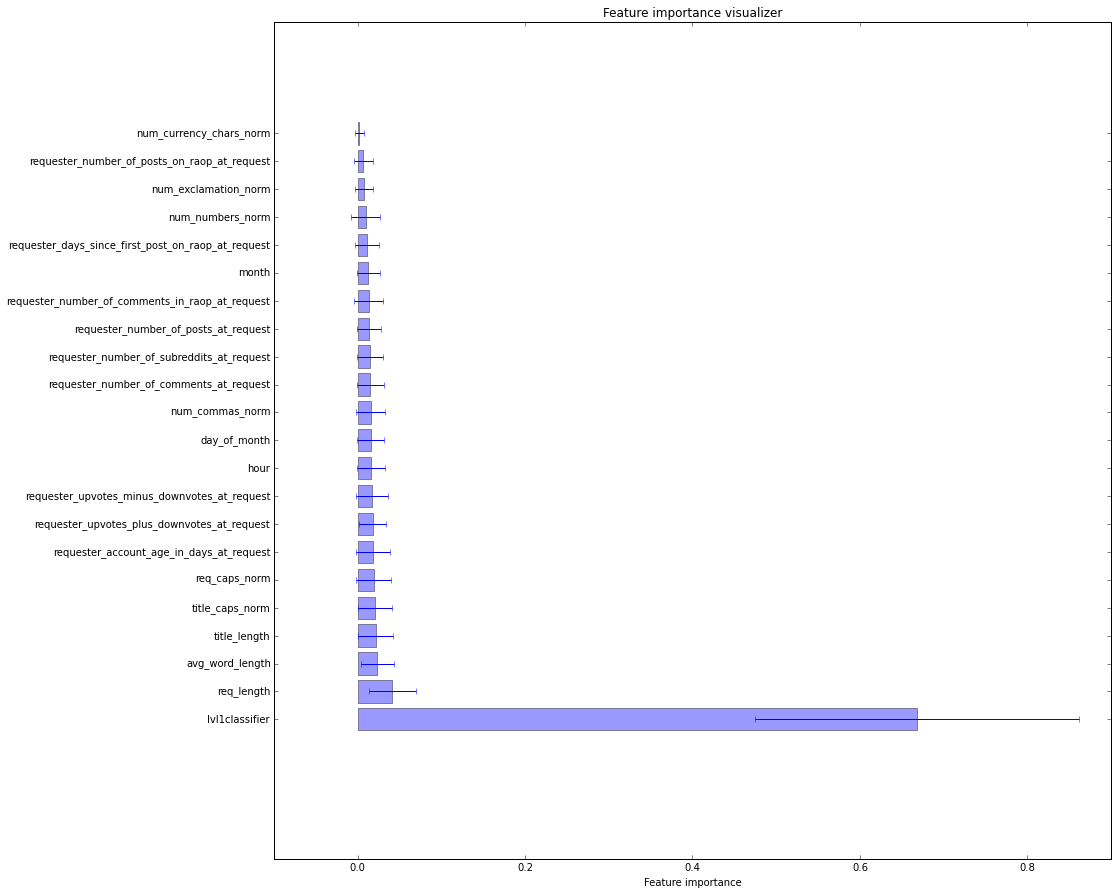

This seems to be a failure in entropy analysis to select important features. 
           The model ranks lvl1classifier very low even though it's standalone performance is better than the RF


In [44]:
compareRF()

{'penalty': 'l1', 'C': 0.092367085718738612}


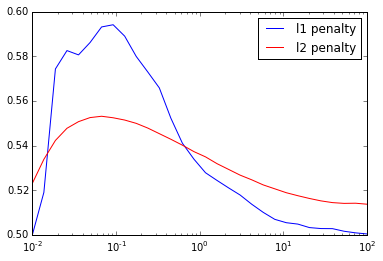

In [69]:
tuneBaseline()

{'criterion': 'entropy', 'max_depth': 5}
[mean: 0.58056, std: 0.01178, params: {'criterion': 'gini', 'max_depth': 2},
 mean: 0.58138, std: 0.02570, params: {'criterion': 'gini', 'max_depth': 3},
 mean: 0.58076, std: 0.01807, params: {'criterion': 'gini', 'max_depth': 4},
 mean: 0.58705, std: 0.02782, params: {'criterion': 'gini', 'max_depth': 5},
 mean: 0.57898, std: 0.02319, params: {'criterion': 'gini', 'max_depth': 6},
 mean: 0.56810, std: 0.00180, params: {'criterion': 'entropy', 'max_depth': 2},
 mean: 0.57497, std: 0.01824, params: {'criterion': 'entropy', 'max_depth': 3},
 mean: 0.60705, std: 0.01338, params: {'criterion': 'entropy', 'max_depth': 4},
 mean: 0.61963, std: 0.01448, params: {'criterion': 'entropy', 'max_depth': 5},
 mean: 0.60138, std: 0.03276, params: {'criterion': 'entropy', 'max_depth': 6}]


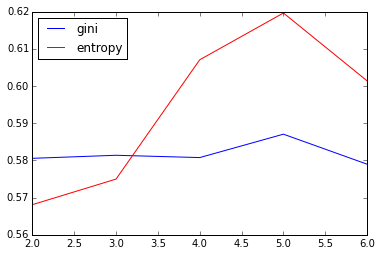

In [183]:
tuneEnsembleTree()

In [142]:
trimWords()

0.535503380143   {'max_df': 0.40000000000000002, 'min_df': 0.0} Words in model:  11529
0.540870446306   {'max_df': 0.44, 'min_df': 0.0} Words in model:  11532
0.536891323507   {'max_df': 0.47999999999999998, 'min_df': 0.0} Words in model:  11534
0.536891323507   {'max_df': 0.52000000000000002, 'min_df': 0.0} Words in model:  11534
0.536891323507   {'max_df': 0.56000000000000005, 'min_df': 0.0} Words in model:  11537
0.536891323507   {'max_df': 0.59999999999999998, 'min_df': 0.0} Words in model:  11537
0.549522663585   {'max_df': 0.40000000000000002, 'min_df': 0.01} Words in model:  761
0.546894542691   {'max_df': 0.44, 'min_df': 0.01} Words in model:  764
0.543535508657   {'max_df': 0.47999999999999998, 'min_df': 0.01} Words in model:  766
0.543535508657   {'max_df': 0.52000000000000002, 'min_df': 0.01} Words in model:  766
0.548939516278   {'max_df': 0.56000000000000005, 'min_df': 0.01} Words in model:  769
0.548939516278   {'max_df': 0.59999999999999998, 'min_df': 0.01} Words in mode

i = 20.0
i = 38.65
i = 57.3
i = 75.95
i = 94.6
i = 113.25
i = 131.9
i = 150.55
i = 169.2
i = 187.85
i = 206.5
i = 225.15
i = 243.8
i = 262.45
i = 281.1
i = 299.75
i = 318.4
i = 337.05
i = 355.7
i = 374.35
i = 393.0
i = 411.65
i = 430.3
i = 448.95
i = 467.6
i = 486.25
i = 504.9
i = 523.55
i = 542.2
i = 560.85
i = 579.5
i = 598.15
i = 616.8
i = 635.45
i = 654.1
i = 672.75
i = 691.4
i = 710.05
i = 728.7
i = 747.35
i = 766.0


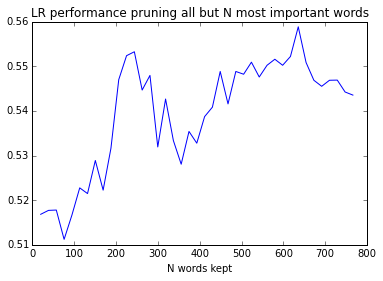

In [144]:
params = {'min_df':0.01,'max_df':0.50}
pruneWords(params)

In [41]:
"""
VISUALISATION Cell
"""

def timeVisualizer():
    '''
    Visualize time related trends. Does RAOP get more or less generous over time? 
    Certain times of day? Certain days of week?
    '''
    raise NotImplementedError

def featureImportanceVisualizer(fitted_model):
    '''
    Takes a fitted model with a 'extractFeatureImportance' method
    plots bar graph of features
    see http://matplotlib.org/examples/lines_bars_and_markers/barh_demo.html for plotting example
    '''
    labs,means,std_devs = fitted_model.extractFeatureImportance()
    err = std_devs*1.96 #95th percentile confidence interval
    
    #plot results
    fig = plt.figure(figsize=(15,15))
    y_pos = np.arange(labs.shape[0])
    plt.barh(y_pos, means, xerr=err, align='center', alpha=0.4)
    plt.yticks(y_pos,labs)
    plt.xlabel('Feature importance')
    plt.title('Feature importance visualizer')
    
    plt.show()
    
def colNamePrint():
    '''
    Just print out TEST column names w indices for ref.
    '''
    c = master_data.getTestColumnNames()
    for i,n in enumerate(c):
        print i, '_',n
    #END    


In [31]:
colNamePrint()

0 _ giver_username_if_known
1 _ request_id
2 _ request_text_edit_aware
3 _ request_title
4 _ requester_account_age_in_days_at_request
5 _ requester_days_since_first_post_on_raop_at_request
6 _ requester_number_of_comments_at_request
7 _ requester_number_of_comments_in_raop_at_request
8 _ requester_number_of_posts_at_request
9 _ requester_number_of_posts_on_raop_at_request
10 _ requester_number_of_subreddits_at_request
11 _ requester_subreddits_at_request
12 _ requester_upvotes_minus_downvotes_at_request
13 _ requester_upvotes_plus_downvotes_at_request
14 _ requester_username
15 _ unix_timestamp_of_request
16 _ unix_timestamp_of_request_utc


In [2]:
'''
TUTORIAL: This cell shows how the dataframes above get accessed and turned into usable numpy arrays
'''

###Task: Extracting message text AND title text into a feature vector:
#first find name of column by printing out the list of names
trainColumnNames = master_data.getTrainColumnNames()
pprint(trainColumnNames) #looks like we want 'request_text_edit_aware' and 'request_title'
#find which number this is or manually type column name
print '\n'
print trainColumnNames[7]
print trainColumnNames[8]

#two ways to get data we want:
print '\n'
X_train = master_data.getTrain()[['request_text_edit_aware','request_title']] #method 1
X_train = master_data.getTrain()[[trainColumnNames[7],trainColumnNames[8]]] #method 2
print X_train.head() #.head() just prints the first 5 rows

#The above X_train is still a pandas dataframe. Converting to numpy array for sklearn is as simple as:
print '\n'
X_train = X_train.values
print type(X_train)
print X_train.shape

#In summary (quick way):
X_train = master_data.getTrain()[['request_text_edit_aware','request_title']].values 

###Task: Join 2 numpy arrays horizontally (e.g. merge train and dev for final submission)
train_data = master_data.getTrain()['request_text_edit_aware'].values
dev_data = master_data.getDev()['request_text_edit_aware'].values
merged_data = np.concatenate((train_data,dev_data),axis=0)
print '\n'
print train_data.shape,' ',dev_data.shape,' ',merged_data.shape

###Task: Join 2 numpy arrays vertically (e.g. add a bunch of features)
train_data1 = master_data.getTrain()['request_text_edit_aware'].values
#now we want more features... say from some feature engineering process
train_data2 = master_data.getTrain()['request_title'].values
train_data_merged = np.column_stack((train_data1,train_data2)) #<---- where the action is at!
print '\n'
print train_data1.shape,' ',train_data2.shape,' ',train_data_merged.shape

###Task: Use the Classes
'''
To use:
1) instantiate your model class
2) initialize it as either test or final
3) run it and either test or finalize it

'''

NameError: name 'master_data' is not defined

In [ ]:
class StackedRegression():
    '''
    Stacking with logistic regression.
    Makes a linear combination of outputs of other models
    http://link.springer.com/article/10.1007%2FBF00117832
    '''
    raise NotImplementedError("Need a 28 hour day")